In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/MyDrive/FYP"

/content/gdrive/MyDrive/FYP


In [ ]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from PIL import Image
from torchsummary import summary

# Class Radiography Dataset

In [ ]:
class RadiographyDataset(Dataset):

    def __init__(self, root, transform=None):
        super().__init__()
        self.data = []
        self.labels = []
        self.transform = transform
        self.classes   = os.listdir(root)

        #get the training samples
        for class_id, cls in enumerate(self.classes):

          cls_folder = os.path.join(root, cls)

          #get the training samples for the class 'cls'
          for img_name in os.listdir(cls_folder):
            self.data.append(os.path.join(cls_folder, img_name))
            self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # get the image
        image = Image.open(self.data[idx])
        image = image.convert('RGB')

        # perform transformation
        if self.transform is not None:
          image = self.transform(image)

        # get the label
        label = self.labels[idx]

        return image, label

# Customizable BLOCK Module

In [ ]:
class BLOCK(nn.Module):

    # ... define the init layer ...
    def __init__(self, blk_cin, blk_cout):

        super().__init__()

        # ... define the convolutional layers ...
        self.conv1 = nn.Conv2d(blk_cin, blk_cout, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(blk_cout, blk_cout, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        # ...  forward propagation ...
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # ... define block 1 ...
        self.conv_block1 = BLOCK(3, 32)

        # ... define block 2 ...
        self.conv_block2 = BLOCK(32, 64)

        # ... define block 3 ...
        self.conv_block3 = BLOCK(64, 128)

        # ... define block 4 ...
        self.conv_block4 = BLOCK(128, 256)

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1         = nn.Linear(256, 10)
        self.fc2         = nn.Linear(10, 3)

    def forward(self, x):

        # ... block 1 ...
        x = self.conv_block1(x)
        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)

        # ... block 2 ...
        x = self.conv_block2(x)
        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)

        # ... block 3 ...
        x = self.conv_block3(x)
        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)

        # ... block 4 ...
        x = self.conv_block4(x)

        # global pool
        x = self.global_pool(x)

        # view
        x = x.view(x.size(0), -1)

        # fc1
        x = self.fc1(x)

        # fc2
        x = self.fc2(x)

        return x

# Train Model

In [ ]:
def train(model, trainloader, valloader, num_epochs, lr=0.01, momentum=0.9, step_size=10, gamma=0.1):

    if torch.cuda.is_available():
      device = torch.device("cuda")

    else:
      device = torch.device("cpu")

    # transfer model to GPU
    model = model.to(device)

    # Release Cache
    gc.collect()
    torch.cuda.empty_cache()

    # set the optimizer. Use the SGD optimizer. Use the lr and momentum settings passed by the user
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # variables
    best_loss = np.inf
    saturate_count = 0
    train_history = []  # save the train loss
    val_history = []    # save the validation loss
    train_acc_history = []  # save the train accuracy
    val_acc_history = []    # save the validation accuracy

    # train the network
    for e in range(num_epochs):

        #running_loss
        running_loss = 0.0
        running_count = 0.0
        running_val_loss = 0.0
        running_val_count = 0.0

        # running_correct
        running_corrects = 0
        running_val_corrects = 0

        #----------------------------train---------------------------------------
        # set to training mode
        model.train()

        # for all batch samples
        for i, (inputs, labels) in enumerate(trainloader):

            # Clear all the gradient to zero
            optimizer.zero_grad()

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss
            loss = F.cross_entropy(outs, labels)

            # backpropagation to get gradients of all parameters
            loss.backward()

            # update parameters
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

            # disable gradient computation
            with torch.no_grad():

              # perform inference
              outputs = model(inputs)

              # predict as the best result
              _, predicted = torch.max(outputs, 1)

              running_corrects += (labels == predicted).double().sum()

        # compute the averaged loss in each epoch
        train_loss = running_loss / running_count
        train_history.append(train_loss)
        running_loss = 0.
        running_count = 0.

        # Update the scheduler's counter at the end of each epoch
        scheduler.step()

        # compute the averaged accuracy in each epoch
        train_acc = 100*running_corrects/len(trainloader.dataset)
        train_acc_history.append(train_acc.item())

        #-----------------------validation---------------------------------------
        # set to eval mode
        model.eval()

        for i, (inputs, labels) in enumerate(valloader):

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss
            loss_val = F.cross_entropy(outs, labels)

            # get the loss
            running_val_loss += loss_val.item()
            running_val_count += 1

            # disable gradient computation
            with torch.no_grad():

              # perform inference
              outputs = model(inputs)

              # predict as the best result
              _, predicted = torch.max(outputs, 1)
              running_val_corrects += (labels == predicted).double().sum()

        # compute the averaged loss in each epoch
        val_loss = running_val_loss / running_val_count
        val_history.append(val_loss)
        running_val_loss = 0.
        running_val_count = 0.

        # compute the averaged accuracy in each epoch
        val_acc = 100*running_val_corrects/len(valloader.dataset)
        val_acc_history.append(val_acc.item())

        print(f'Epoch {e+1:2d}/{num_epochs:d} : train_loss = {train_loss:.4f} | val_loss = {val_loss:.4f}' + ' ------- train_acc = {:.2f}%'.format(train_acc) + ' | val_acc = {:.2f}%'.format(val_acc))

        # create save model folder
        if not os.path.exists("./custom_models"):
          os.mkdir("custom_models")

        # save the model
        checkpoint_file = './custom_models/saved_model.pt'
        torch.save({
            'epoch': e,
            'loss': train_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_file)

    print("Training completed.")
    return train_history, val_history, train_acc_history, val_acc_history

# Evaluate Model

In [ ]:
def evaluate(model, testloader):

    # set to evaluation mode
    model.eval()

    pred = []  # save the all prediction
    true_label = []  # save the all true label
    # running_correct
    running_corrects = 0
    acc = 0

    # Repeat for all batch data in the test set
    for inputs, targets in testloader:

        # transfer to the GPU
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()

        # # disable gradient computation
        with torch.no_grad():

            # perform inference
            outputs = model(inputs)

            # predict as the best result
            _, predicted = torch.max(outputs, 1)
            running_corrects += (targets == predicted).double().sum()
            predicted = predicted.cpu().numpy()
            pred.append(predicted)
            targets = targets.cpu().numpy()
            true_label.append(targets)

    print('Accuracy = {:.2f}%'.format(100*running_corrects/len(testloader.dataset)))
    return pred, true_label

# Loss graph

In [ ]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss)+1)
    plt.plot(epochs, train_loss, label='train loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.ylabel('Loss', fontsize=13)
    plt.xlabel('epochs', fontsize=13)
    plt.title('Loss vs epochs', fontsize=18)
    plt.legend()
    plt.show()


# Accurarcy graph

In [ ]:
def plot_history_acc(train_acc, val_acc):
    epochs = range(1, len(train_acc)+1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_acc, color='red', label='train_acc')
    plt.plot(epochs, val_acc, color='blue', label='val_acc')
    plt.ylabel('Accuracy', fontsize=13)
    plt.xlabel('epochs', fontsize=13)
    plt.title('Training vs Validation Accuracy', fontsize=18)
    plt.legend()
    plt.show()

Check the dataset images number

In [ ]:
classes = ['COVID', 'Normal', 'Viral Pneumonia']

total_ori = 0
ori_path = './COVID-19_Radiography_Dataset/'
for cls in classes:
  total_ori += len(os.listdir(ori_path + cls + '/images'))
print('Total of original datasets         : ', total_ori)
print('---------------------------------------------\n')

print('Train-Covid                        : ', len(os.listdir('./Radiography_Data/train/COVID')))
print('Train-Normal                       : ', len(os.listdir('./Radiography_Data/train/Normal')))
print('Train-Viral Pneumonia              : ', len(os.listdir('./Radiography_Data/train/Viral Pneumonia')))

print('\nValidation-Covid                   : ', len(os.listdir('./Radiography_Data/val/COVID')))
print('Validation-Normal                  : ', len(os.listdir('./Radiography_Data/val/Normal')))
print('Validation-Viral Pneumonia         : ', len(os.listdir('./Radiography_Data/val/Viral Pneumonia')))

print('\nTest-Covid                         : ', len(os.listdir('./Radiography_Data/test/COVID')))
print('Test-Normal                        : ', len(os.listdir('./Radiography_Data/test/Normal')))
print('Test-Viral Pneumonia               : ', len(os.listdir('./Radiography_Data/test/Viral Pneumonia')))

print('---------------------------------------------\n')
new_path = './Radiography_Data/'
folder = ['train', 'val', 'test']
total_new = 0
for fld in folder:
  for cls in classes:
    total_new += len(os.listdir(new_path + fld + '/' + cls))

print('Total of Train, Val, Test datasets : ', total_new)

Total of original datasets         :  15153
---------------------------------------------

Train-Covid                        :  2892
Train-Normal                       :  8153
Train-Viral Pneumonia              :  1076

Validation-Covid                   :  362
Validation-Normal                  :  1019
Validation-Viral Pneumonia         :  134

Test-Covid                         :  362
Test-Normal                        :  1020
Test-Viral Pneumonia               :  135
---------------------------------------------

Total of Train, Val, Test datasets :  15153


Show the sample images

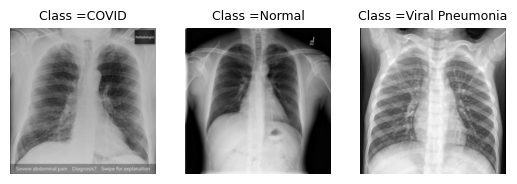

In [ ]:
sampleset = RadiographyDataset("./Radiography_Data/train", transform=None)

image_1, label_1 = sampleset[1]
image_2, label_2 = sampleset[2893]
image_3, label_3 = sampleset[11047]

plt.subplot(1, 3, 1)
plt.imshow(image_1)
plt.title('Class =' + sampleset.classes[label_1], fontsize=9)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_2)
plt.title('Class =' + sampleset.classes[label_2], fontsize=9)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_3)
plt.title('Class =' + sampleset.classes[label_3], fontsize=9)
plt.axis('off')

plt.show()

The network layout

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")

else:
  device = torch.device("cpu")

sample_net = Net()
sample_net = sample_net.to(device)
summary(sample_net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]           9,248
             BLOCK-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
            Conv2d-5         [-1, 64, 112, 112]          36,928
             BLOCK-6         [-1, 64, 112, 112]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
            Conv2d-8          [-1, 128, 56, 56]         147,584
             BLOCK-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
           Conv2d-11          [-1, 256, 28, 28]         590,080
            BLOCK-12          [-1, 256, 28, 28]               0
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
           Linear-14                   

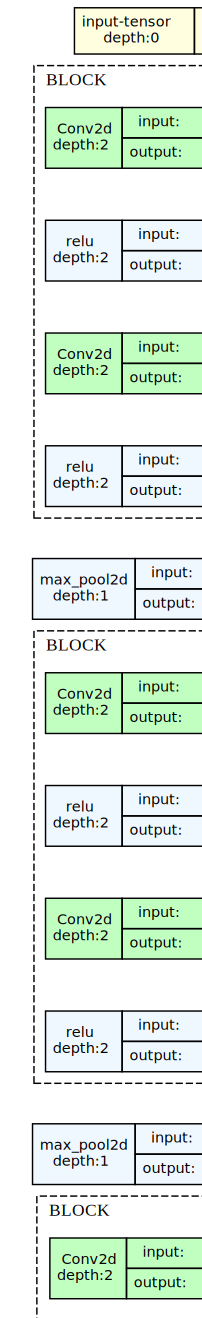

In [ ]:
!pip install torchview
import torchvision
from torchview import draw_graph

model_graph = draw_graph(sample_net, input_size=(4,3,224,224), expand_nested=True)
model_graph.visual_graph

# Transformation of Images

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform the model
train_transform = transforms.Compose([
    transforms.Resize(256),                                # output: PIL Image of resolution(256, 256)
    transforms.RandomCrop(224),                            # output: PIL Image of resolution(224, 224)
    transforms.RandomHorizontalFlip(),                     # output: PIL Image of resolution(224, 224)
    transforms.ToTensor(),                                 # output: tensor, dtype = float32, shape = (3, 224, 224), range:[0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # output: same as before except range changes such that mean = 0, std = 1
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Load the dataset using DataLoader

In [ ]:
#Load the dataset
trainset = RadiographyDataset("./Radiography_Data/train", transform=train_transform)
valset  = RadiographyDataset("./Radiography_Data/val", transform=val_transform)

batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader  = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

Start training

In [ ]:
net = Net()
train_loss, val_loss, train_acc, val_acc = train (net, trainloader, valloader, num_epochs=100, lr=0.01, momentum=0.9, step_size=40)

Epoch  1/100 : train_loss = 0.8382 | val_loss = 0.8190 ------- train_acc = 66.23% | val_acc = 67.26%
Epoch  2/100 : train_loss = 0.8246 | val_loss = 0.8241 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  3/100 : train_loss = 0.8239 | val_loss = 0.8186 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  4/100 : train_loss = 0.8197 | val_loss = 0.8046 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  5/100 : train_loss = 0.8024 | val_loss = 0.8004 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  6/100 : train_loss = 0.7974 | val_loss = 0.8013 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  7/100 : train_loss = 0.7940 | val_loss = 0.7737 ------- train_acc = 67.26% | val_acc = 67.26%
Epoch  8/100 : train_loss = 0.7127 | val_loss = 0.6757 ------- train_acc = 68.96% | val_acc = 69.31%
Epoch  9/100 : train_loss = 0.6608 | val_loss = 0.6252 ------- train_acc = 70.36% | val_acc = 70.23%
Epoch 10/100 : train_loss = 0.6353 | val_loss = 0.6644 ------- train_acc = 71.15% | val_acc

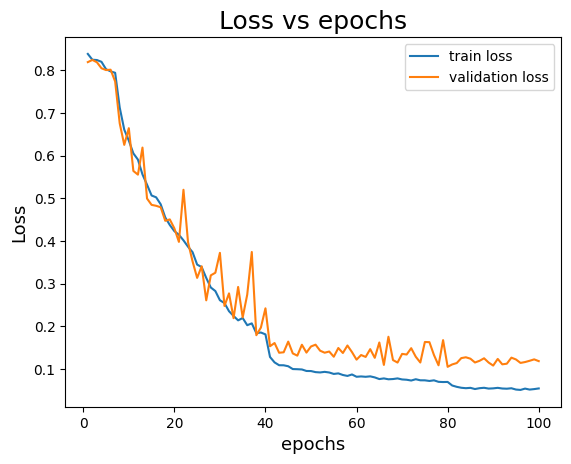

In [ ]:
plot_loss(train_loss, val_loss)

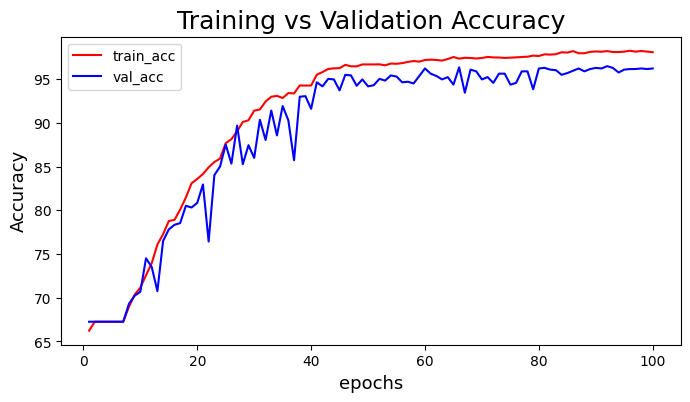

In [ ]:
plot_history_acc(train_acc, val_acc)

Evaluate model

In [ ]:
# transform the model
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32
testset = RadiographyDataset("./Radiography_Data/test", transform=test_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
pred, true_label = evaluate(net, testloader)

Accuracy = 97.17%


# Confusion Matrix

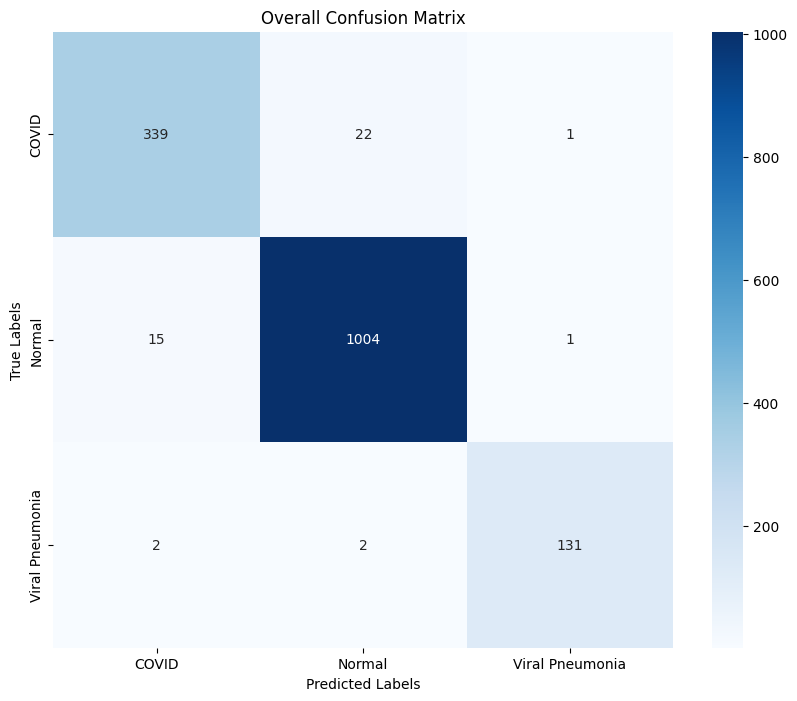

In [ ]:
import seaborn as sns
class_names = ['COVID', 'Normal', 'Viral Pneumonia']

pred0 = pred[0]
label0 = true_label[0]

for p in pred[1:]:
  pr = np.concatenate((pred0, p))
  pred0 = pr

for l in true_label[1:]:
  lb = np.concatenate((label0, l))
  label0 = lb

# Confusion matrix
cm = confusion_matrix(label0, pred0)

# Visualize the overall confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(label0, pred0, target_names=class_names)

# Print the classification report
print(report)


                 precision    recall  f1-score   support

          COVID       0.95      0.94      0.94       362
         Normal       0.98      0.98      0.98      1020
Viral Pneumonia       0.98      0.97      0.98       135

       accuracy                           0.97      1517
      macro avg       0.97      0.96      0.97      1517
   weighted avg       0.97      0.97      0.97      1517

